In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

c:\Users\sgnik\OneDrive\Рабочий стол\Python project\S_16_EDA_stepik\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("abalone.csv")
df.head(-5)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,NaN,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4167,M,0.500,0.380,0.125,0.5770,0.2690,0.1265,0.1535,9
4168,F,0.515,0.400,0.125,0.6150,0.2865,0.1230,0.1765,8
4169,M,0.520,0.385,0.165,0.7910,0.3750,0.1800,0.1815,10
4170,M,0.550,0.430,0.130,0.8395,0.3155,0.1955,0.2405,10


## Описание данных

* Sex - nominal - M, F, and I (infant)

* Length - continuous - mm - Longest shell measurement

* Diameter - continuous - mm - perpendicular to length

* Height - continuous - mm - with meat in shell

* Whole weight - continuous - grams - whole abalone

* Shucked weight - continuous - grams - weight of meat

* Viscera weight - continuous - grams - gut weight (after bleeding)

* Shell weight - continuous - grams - after being dried

* Rings - integer - +1.5 gives the age in years (target)

Обрабатываем пропуски в исходном датасете и создаем целевую переменную из признака Rings

In [3]:
median_diameter = df['Diameter'].median()
median_weight_1 = df['Whole weight'].median()
median_weight_2 = df['Shell weight'].median()
df['Sex'] = df['Sex'].replace('f', 'F')
df.fillna({'Diameter': median_diameter, 'Whole weight': median_weight_1, 'Shell weight': median_weight_2}, inplace=True)
df['age'] = df['Rings'].apply(lambda x: x + 1.5)
df.columns = df.columns.str.lower()
df.isnull().mean() * 100

sex               0.0
length            0.0
diameter          0.0
height            0.0
whole weight      0.0
shucked weight    0.0
viscera weight    0.0
shell weight      0.0
rings             0.0
age               0.0
dtype: float64

# Part I

## Наивный байесовский классификатор

Для использования Наивного байесовского классификатора на нужно превратить нашу целевую числовую функцию age в категориальную. Так как мы знаем, что взрослые особи обоих полов из нашей выборки имеют одинаковый медианный возраст 11.5, а младенцы 9.5. Тогда кажется логичным, разделить на два класса взрослые и младенцы, используя среднее арифметическое значение медианных возрастов особей из выборки: $$ \frac{(11.5+9.5)}{2}\ = 10.5 $$

In [4]:
age_stats = df.groupby('sex')['age'].agg(['mean', 'median', 'count'])
age_stats

,mean,median,count
sex,,,
F,12.501376,11.5,1454
I,9.372257,9.5,1276
M,12.178645,11.5,1447


In [5]:
X = df[['length', 'diameter', 'height', 'whole weight', 'shucked weight', 'viscera weight', 'shell weight']] 
y = df['age']

y_class = (y > 10.5).astype(int)

Разделим наш набор данных на обучающий и проверочные наборы:

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.25, random_state=42)

И обучим классификатор Байеса

In [7]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

accuracy_score(y_test, y_pred)

0.7301435406698564

Точность модели составила 73% - это доля правильных прогнозов от всего их количества.

### Используем другую модель: классификатор KNN для прогнозирования возраста абалонов

In [8]:
knn_cl = KNeighborsClassifier()
knn_cl.fit(X_train, y_train)
pred_knn = knn_cl.predict(X_test)
accuracy_score(y_test, pred_knn)

0.7732057416267942

Точность модели KNN составила 77% - это доля правильных прогнозов от всего их количества, что на 4% выше наивного байесовского классификатора.

Так же рассмотрим модель линейной регрессии, так как к ней нельзя применить метрику accuracy, то используем коэффициент детерминации:

In [11]:
line_reg = LinearRegression()
line_reg.fit(X_train, y_train)
pred_linreg = line_reg.predict(X_test)
r2_score(y_test, pred_linreg)

0.3512095995701976

Основным ограничением Гаусово наивного байесовского классификатора является предположение о независимости признаков, которое редко подтверждается на практике. Так же для этого классификатора предполагается, что целевая переменная распределена нормально. Обратимся к ноутбуку EDA, ниже приложена матрица отношений признаков между друг другом, а по главной диагонали распределение соотвествующих признаков. Откуда видно, что распределение целевой переменной логнормальное.

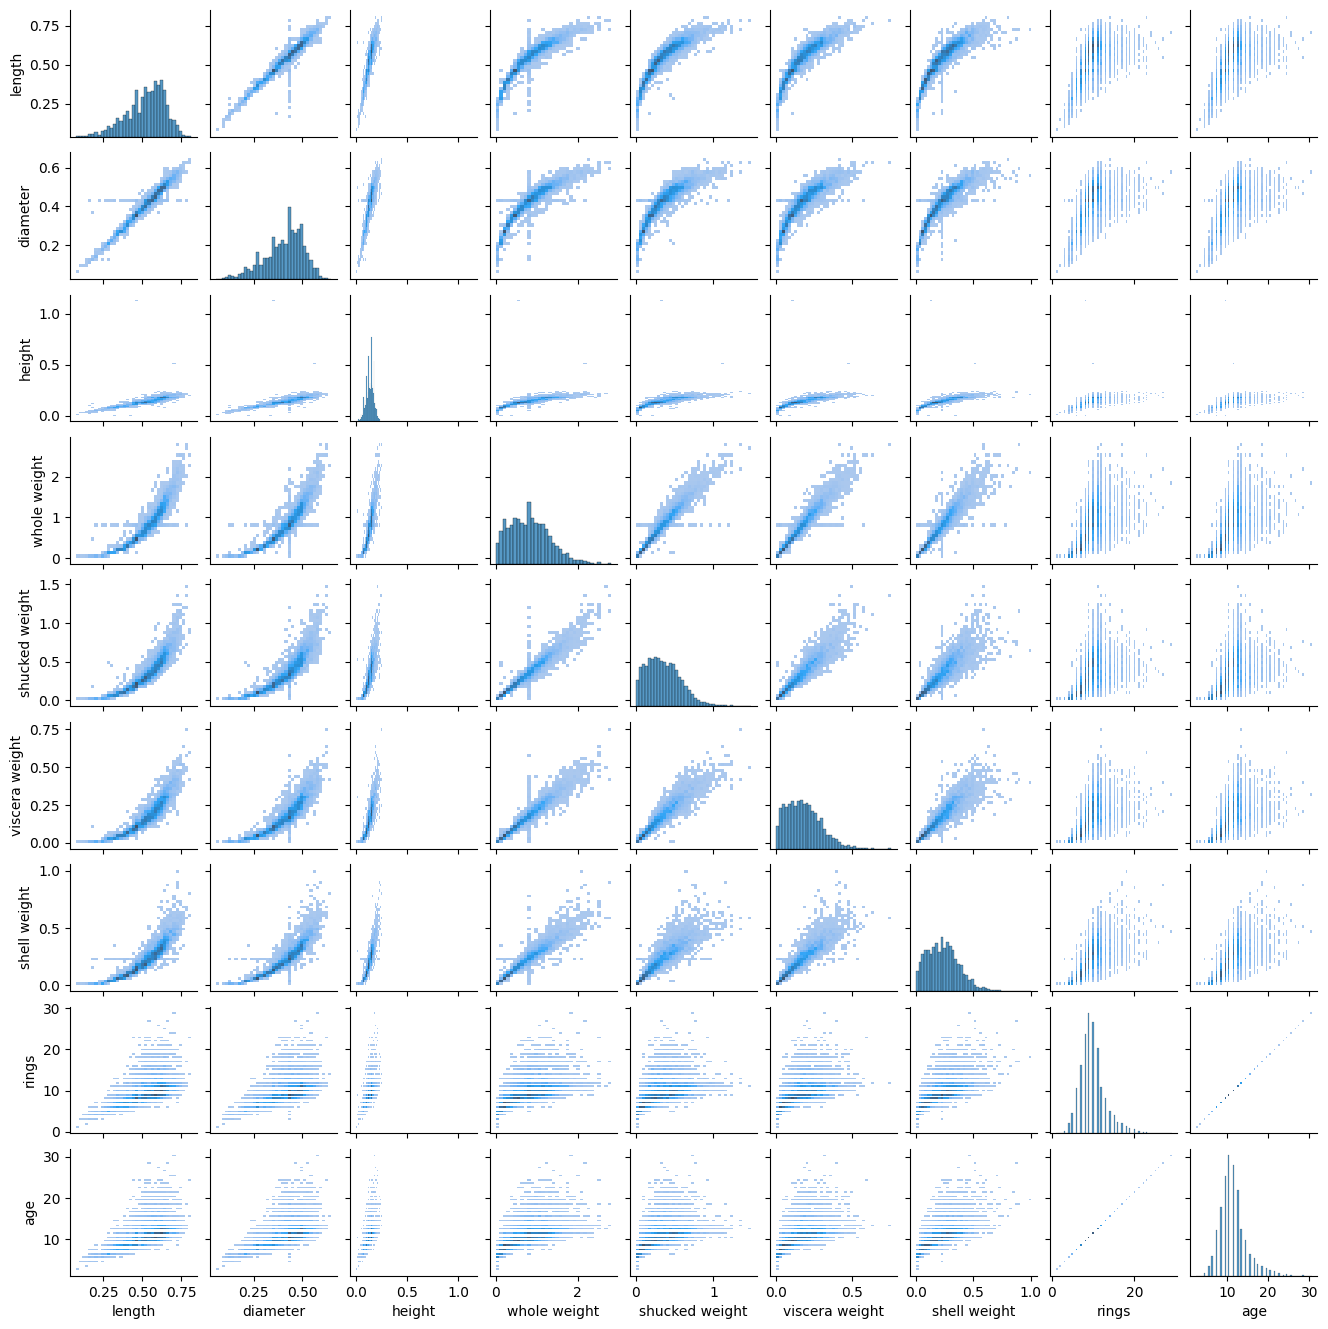

In [12]:
sns.pairplot(df, kind = 'hist', height=1.5, aspect=1)

прологарифмируем числовые признаки нашего набора данных и попробуем обучить модели классификаторов еще раз.

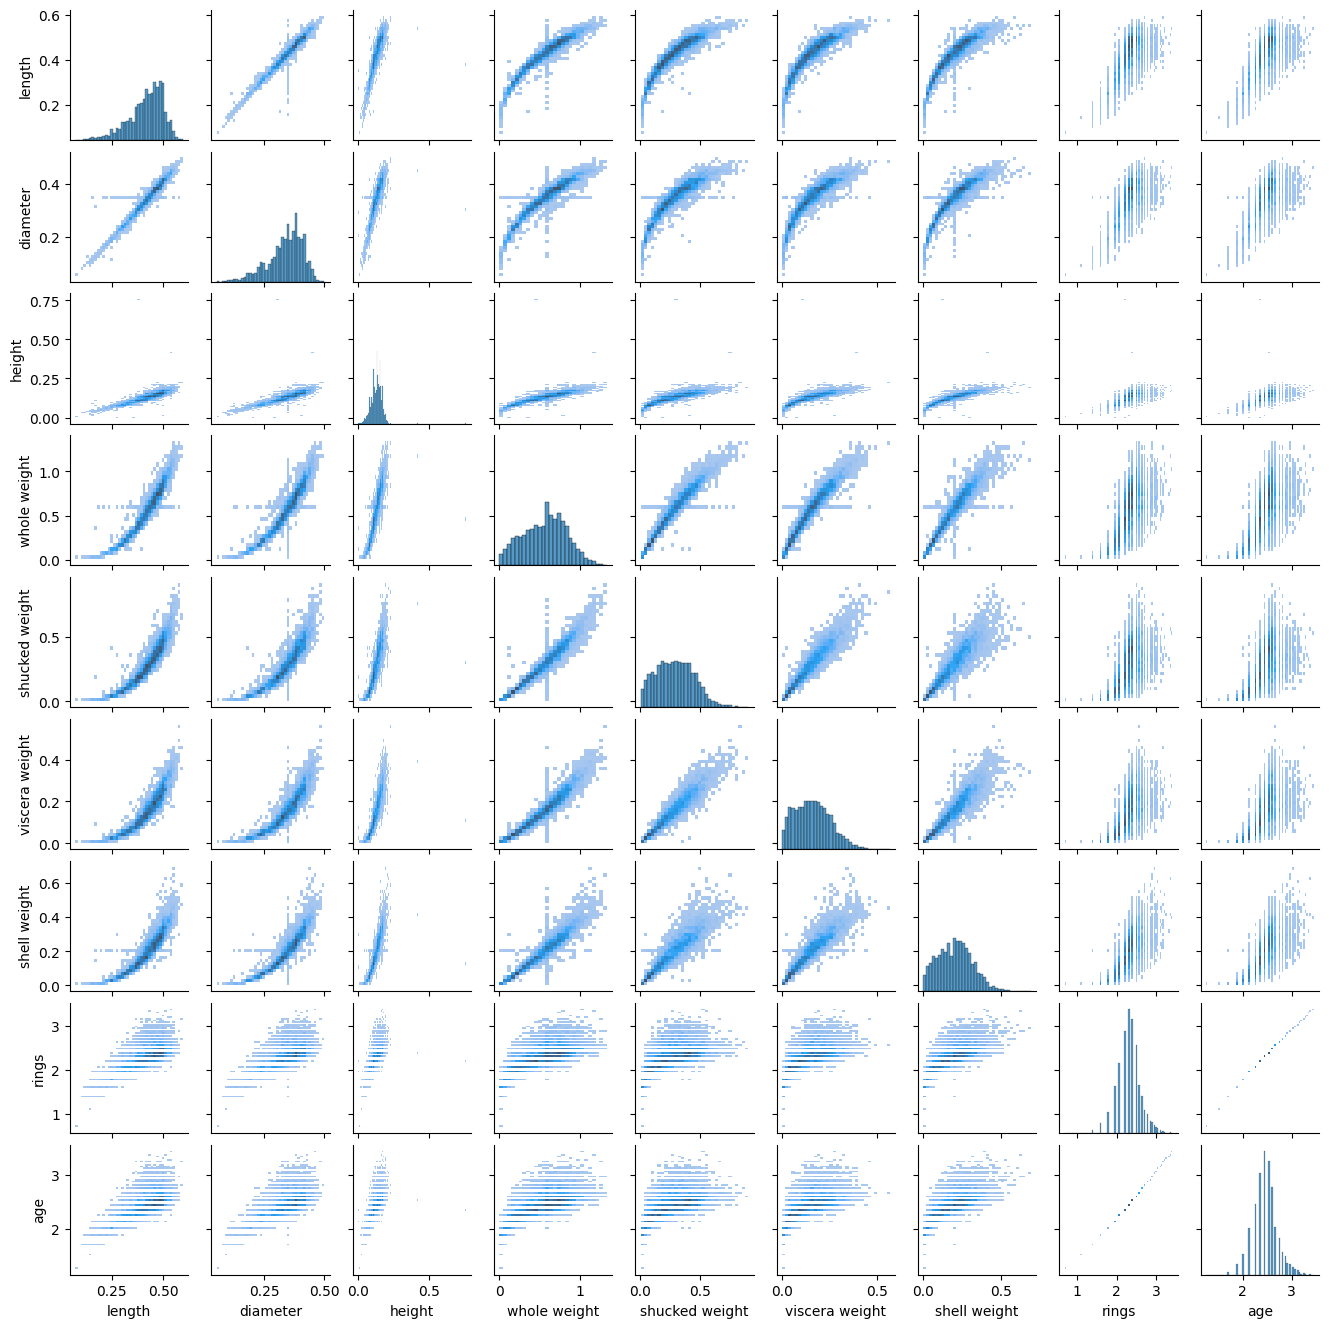

In [13]:
numeric_features = df.select_dtypes(include=[np.number]).columns

for feature in numeric_features:
    df[feature] = np.log1p(df[feature])

sns.pairplot(df, kind = 'hist', height=1.5, aspect=1)

Повоторим разделение набора переменных на обучающий и тестовый наборы числовых признаков. Так же после логарифмирования изменятся значения для создания классов возраста

In [14]:
age_stats = df.groupby('sex')['age'].agg(['mean', 'median', 'count'])
age_stats

,mean,median,count
sex,,,
F,2.578668,2.525729,1454
I,2.312642,2.351375,1276
M,2.554449,2.525729,1447


Граница возраста между классами взрослая особь/младенец:

$$ \frac{2.52 + 2.35}{2} = 2.44 $$

In [15]:
X = df[['length','diameter','height','whole weight', 'shucked weight', 'viscera weight', 'shell weight']] 
y = df['age']
y_class = (y > 2.44).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.25, random_state=42)

Повторим обучение Гауссова Наивного Байеса и проверим изменение точности предсказания

In [16]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

accuracy_score(y_test, y_pred)

0.8086124401913876

Точность модели повысилась с 73% до 81% на 8%.

Повторим обучение KNN с гиперпараметрами по умолчанию

In [17]:
knn_cl = KNeighborsClassifier()
knn_cl.fit(X_train, y_train)
pred_knn = knn_cl.predict(X_test)
accuracy_score(y_test, pred_knn)

0.8258373205741627

Точность модели KNN повысилась с 77% до 83% на 5%. Таким образом обе модели показали хорошее качество прогноза, что объясняется так же малым количеством классов (взрослая особь, младенец). Замечено, что подготовка данных оказывает существенное влияние на качество модели. В завершении этой части задания обучим и оценим точность модели линейной регрессии.

Разделение 

In [18]:
line_reg = LinearRegression()
line_reg.fit(X_train, y_train)
pred_linreg = line_reg.predict(X_test)
r2_score(y_test, pred_linreg)

0.42174904899960464

Коэффициент детерминации модели линейной регресии после логарифмирования признаков повысился на 20% с 0.35 до 0.42. Стоит отметить, что для корректной интерпретации результатов моделей после применения логарифмирования признаков необходимо произвести расчет экспоненциальной функции от этих признаков (то есть операцию обратную логарифмированию)

# Part II

Что бы все работало, так как предполагается загрузим исходные данные снова и проведем их преобработку

In [89]:
df = pd.read_csv("abalone.csv")
median_diameter = df['Diameter'].median()
median_weight_1 = df['Whole weight'].median()
median_weight_2 = df['Shell weight'].median()
df['Sex'] = df['Sex'].replace('f', 'F')
df.fillna({'Diameter': median_diameter, 'Whole weight': median_weight_1, 'Shell weight': median_weight_2}, inplace=True)
df['age'] = df['Rings'].apply(lambda x: x + 1.5)
df = df.drop('Rings', axis=1) # удалим признак Rings, как родителя целевой переменной
df.columns = df.columns.str.lower()

Выполним подбор гиперпараметров у каждой из моделей при помощи GridSearchCV, а так же вычислим метрики для лучших найденных моделей. Используем пайплайн для получения результатов по 3 моделям сразу. Предварительно отмасштабируем наши числовые признаки при помощи ColumnTransformer и добавим учет категориального признака 'sex'

При этом замечено, если логарифмировать признаки перед подбором оптимальных гиперпараметров через грид, то accuracy становится 1 для моделей классификаторов (байес и knn), градиентный бустинг выполняется с ошибкой ('y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.').

In [90]:
X = df.drop(['age', 'sex'], axis=1)
y = df['age']
y_class = (y > 10.5).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.25, random_state=42)

In [75]:
gnb = GaussianNB()

params = {'var_smoothing': np.logspace(0, -9, num=100)}
gs = GridSearchCV(gnb, params, scoring='accuracy', cv=3, n_jobs=-1, verbose=5)
gs.fit(X_train, y_train)
print(gs.best_score_, gs.best_params_)
pred = gs.best_estimator_.predict(X_test)
accuracy_score(y_test, pred)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
0.7353128991060025 {'var_smoothing': np.float64(0.0003511191734215131)}


0.7291866028708134

In [76]:
knn_cl = KNeighborsClassifier()

params = {'n_neighbors' : np.arange(2, 20, 2),
          'weights' : ['uniform', 'distance']}

gs = GridSearchCV(knn_cl, params, scoring='accuracy', cv=3, n_jobs=-1, verbose=5)
gs.fit(X_train, y_train)
print(gs.best_score_, gs.best_params_)
pred = gs.best_estimator_.predict(X_test)
accuracy_score(y_test, pred)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
0.7854406130268199 {'n_neighbors': np.int64(12), 'weights': 'distance'}


0.785645933014354

In [91]:
gb_cl = GradientBoostingClassifier(random_state=42)

params = {
    'n_estimators': np.arange(50, 250, 50),  # Количество деревьев в лесу
    'max_depth': [3, 10, 20, 30],  # Максимальная глубина дерева
    'subsample': [0.1, 0.5, 1.0],  # параметр для использования стохастического градиентного бустинга
}

gs = GridSearchCV(gb_cl, params, scoring='r2', cv=3, n_jobs=-1, verbose=5)
gs.fit(X_train, y_train)
print(gs.best_score_, gs.best_params_)
pred = gs.best_estimator_.predict(X_test)
accuracy_score(y_test, pred)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
0.15835889676269108 {'max_depth': 3, 'n_estimators': np.int64(50), 'subsample': 0.5}


0.7875598086124402

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

rf = RandomForestRegressor(random_state=42)

params = {
    'n_estimators': np.arange(50, 250, 50),  # Количество деревьев в лесу
    'max_depth': [None, 10, 20, 30],  # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10],  # Минимальное количество образцов для разделения узла
    'min_samples_leaf': [1, 2, 4],    # Минимальное количество образцов в листе
    'bootstrap': [True, False]        # Использовать или нет бутстреп
}

gs = GridSearchCV(rf, params, scoring='r2', cv=3, n_jobs=-1, verbose=5)
gs.fit(X_train, y_train)
print(gs.best_score_, gs.best_params_)
pred = gs.best_estimator_.predict(X_test)
r2_score(y_test, pred)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


c:\Users\sgnik\OneDrive\Рабочий стол\Python project\S_16_EDA_stepik\.venv\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


0.54404914468028 {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': np.int64(50)}


0.5358108581715544

Таким образом модель классификатора градиентного бустинга показывает большую точность чем остальные классификаторы, так как не понятно как сравнивать качество моделей классификационных с регрессионными. Если говорить о модели случайного леса, то подбор гиперпараметров позволил увеличить коэффициент детерминации с 0.42 до 0.54, т.е. на 29%

# Part III

Добавим использование категориального признака и повторим обучение модели градиентного бустинга с использованием грида. 

In [93]:
X_full = df.drop('age', axis=1)
y = df['age']
y_class = (y > 10.5).astype(int)
X_train_f, X_test_f, y_train_full, y_test_full = train_test_split(X_full, y_class, test_size=0.25, random_state=42)

categorical_feature = ['sex']
numeric_features = ['length', 'diameter', 'height', 'whole weight', 'shucked weight',
                     'viscera weight', 'shell weight']

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_feature),
    ('scaling', MinMaxScaler(), numeric_features)
])

X_train_transformed = ct.fit_transform(X_train_f)
X_test_transformed = ct.transform(X_test_f)

Так как результатом ColumnTranformer являются массивы numpy.ndarray, то трансформируем их обратно в формат pandas.DataFrame

In [94]:
X_train_transformed = pd.DataFrame(X_train_transformed, columns=new_features)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=new_features)

X_train_transformed.head()

,sex_F,sex_I,sex_M,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight
0,1.0,0.0,0.0,0.729730,0.672269,0.119469,0.374358,0.317754,0.345622,0.271550
1,1.0,0.0,0.0,0.594595,0.571429,0.123894,0.242253,0.188299,0.164582,0.217738
2,0.0,0.0,1.0,0.790541,0.798319,0.154867,0.559943,0.496638,0.460829,0.402093
3,0.0,0.0,1.0,0.513514,0.521008,0.084071,0.181335,0.150303,0.132324,0.147982
4,0.0,0.0,1.0,0.567568,0.579832,0.137168,0.285638,0.157028,0.151415,0.347285


Таким образом получаем следующие признаки:

In [95]:
new_features = list(ct.named_transformers_['ohe'].get_feature_names_out())
new_features.extend(numeric_features)

new_features

['sex_F',
 'sex_I',
 'sex_M',
 'length',
 'diameter',
 'height',
 'whole weight',
 'shucked weight',
 'viscera weight',
 'shell weight']

In [96]:
gb_cl = GradientBoostingClassifier(random_state=42)

params = {
    'n_estimators': np.arange(50, 250, 50),  # Количество деревьев в лесу
    'max_depth': [3, 10, 20, 30],  # Максимальная глубина дерева
    'subsample': [0.1, 0.5, 1.0],  # параметр для использования стохастического градиентного бустинга
}

gs = GridSearchCV(gb_cl, params, scoring='r2', cv=3, n_jobs=-1, verbose=5)
gs.fit(X_train_transformed, y_train_full)
print(gs.best_score_, gs.best_params_)
pred = gs.best_estimator_.predict(X_test_transformed)
accuracy_score(y_test_full, pred)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
0.1928420350374813 {'max_depth': 3, 'n_estimators': np.int64(100), 'subsample': 1.0}


0.7894736842105263

Добавление категориального признака 'sex' в модель незначительно повысило точность модели, что может говорить и низкой важности данного признака и незначительности его влияния на целевую переменную 'age'

# Part IV

Построим Explainer Dashboard и проанализируем результаты

In [97]:
explainer = ClassifierExplainer(gs.best_estimator_, X_test_transformed.iloc[:10], y_test_full.iloc[:10])

Note: model_output=='probability'. For GradientBoostingClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...


In [98]:
db = ExplainerDashboard(explainer)

Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating pred_percentiles...
Calculating predictions...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.jobl

In [ ]:
db.run()

Starting ExplainerDashboard on http://100.88.31.15:8050


ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=8050): Max retries exceeded with url: /_alive_ad658559-85a7-4e3d-9e99-9297dd4c7193 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001A7C991E5C0>: Failed to establish a new connection: [WinError 10049] Требуемый адрес для своего контекста неверен'))

c:\Users\sgnik\OneDrive\Рабочий стол\Python project\S_16_EDA_stepik\.venv\lib\site-packages\explainerdashboard\explainer_plots.py:421: RuntimeWarning:

invalid value encountered in scalar divide

[2024-07-14 00:12:04,334] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "c:\Users\sgnik\OneDrive\Рабочий стол\Python project\S_16_EDA_stepik\.venv\lib\site-packages\flask\app.py", line 1473, in wsgi_app
    response = self.full_dispatch_request()
  File "c:\Users\sgnik\OneDrive\Рабочий стол\Python project\S_16_EDA_stepik\.venv\lib\site-packages\flask\app.py", line 882, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "c:\Users\sgnik\OneDrive\Рабочий стол\Python project\S_16_EDA_stepik\.venv\lib\site-packages\flask\app.py", line 880, in full_dispatch_request
    rv = self.dispatch_request()
  File "c:\Users\sgnik\OneDrive\Рабочий стол\Python project\S_16_EDA_stepik\.venv\lib\site-packages\flask\app.py", line 865, in dis

Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty Da

1. По анализу дашбоардов можно сделать выводы, что в среднем для получения прогноза важны (по Permutation Importances и SHAP values): 
* shell weight
* shucked weight

2. Изменяя Cutoff percentile of samples от 0 до 0.99 параметры изменяются Model performance metrics в частности accuracy в диапазоне от 0.5 - 0.7, что может говорить о несбалансированности выборки. Доля положительных результатов не увеличивается с ростом предсказанной вероятности, что может свидетельствовать об устойчивости результатов модели на тестовой выборке.

3. 
    * Идивидуальный прогноз с индексом 4. 60.4 % вероятности, что особь взрослая. Такой прогноз основан на том, что признаки геометрических размеров особи приближены к медианным значениям популяции
    * Индивидуальный проноз с индексом 7. 80% вероятности, что особь - младенец. Об этом свидетельствуют низкие значения геометрических размеров особи. Хотя судя по тому, что трансформированный через энкодер параметр пола особи для данного варианта имеет значение 1 для столбца sex_M, может значить, что модель здесь ошиблась.
    * Идивидуальный прогноз с индексом 2. 97% вероятности, что особь взрослая. Здесь модель однозначно классифицировала верно, используя признаки геометрических размеров и категориальный признак пола особи.  

